In [ ]:
!pip install ete3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 20.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ete3: filename=ete3-3.1.3-py3-none-any.whl size=2273787 sha256=7f55807ee5b9060e03fac274ea184db5b8a1a8028a5c1c232dcbf50814ec34b5
  Stored in directory: /root/.cache/pip/wheels/a0/72/00/1982bd848e52b03079dbf800900120bc1c20e92e9a1216e525
Successfully built ete3


## Circular Pruning Algorithm

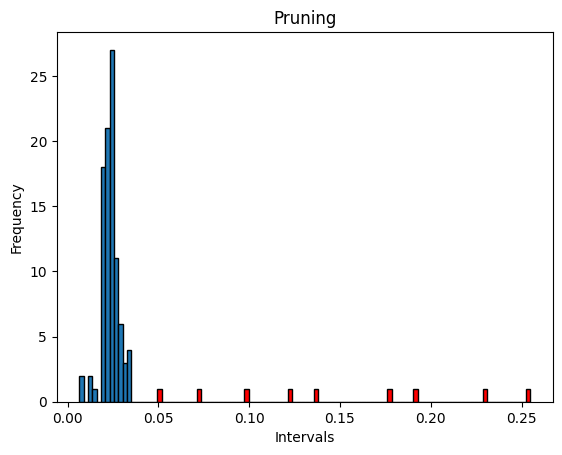

We left 91.34615384615384 percent of the leaves


In [ ]:
from ete3 import Tree
import numpy as np
import matplotlib.pyplot as plt
import random


# READING THE NEWICK FILE
name_of_the_tree = "ST2332.nwk"  # INPUT YOUR TREE HERE
tree = Tree(name_of_the_tree, format = 1, quoted_node_names=True)
leaf_names = tree.get_leaf_names()
num_leaves = len(leaf_names) # COUNTING THE NUMBER OF LEAVES
original_num_leaves = num_leaves

#=======================================================
# THE PARAMETERS YOU CAN SET:
#=======================================================
root_to_node_ratio = 0.1  # YOU HAVE TO DECIDE WHAT PORTION OF THE NON-LEAF NODES YOU WANT TO CALL ROOTS
min_num_of_roots = 15     # YOU CAN SET THE MINIMUM NUMBER OF ROOTS TO HANG THE TREE FROM
M_n = num_leaves          # THIS IS M(n), THE NUMBER OF INTERVALS
alpha = 90                # WE WANT TO LEAVE AT LEAST alpha PERCENT OF THE LEAVES
beta = 20                 # WE ONLY CUT IF THE FREQUENCY DROPS BY AT LEAST beta PERCENT
#=======================================================
# THE REST OF THE CODE IS PRE-DETERMINED
#=======================================================


# HANGING THE TREE (ROOT-TO-TIP DISTANCES)
def hang(tree1, root1):
    dists = []
    for leaf in tree1.iter_leaves():
        distance = tree1.get_distance(root1, leaf)
        dists.append(distance)
    return dists


# COUNTING THE NON-LEAF NODES
non_leaf_nodes = []
num_non_leaf_nodes = 0
for node in tree.traverse():
    if not node.is_leaf():
        non_leaf_nodes.append(node)
        num_non_leaf_nodes += 1

num_nodes = num_leaves + num_non_leaf_nodes

# SELECTING THE ROOTS
num_roots = min(max(int(root_to_node_ratio * num_non_leaf_nodes), min_num_of_roots), num_non_leaf_nodes)
roots = random.sample(non_leaf_nodes, num_roots)
midpoint_root = tree.get_midpoint_outgroup()
roots.append(midpoint_root)


# THE MAIN LOOP
best_p_v = float("inf")
for root in roots:
    data = hang(tree, root)
    interval_width = (max(data) - min(data)) / M_n
    bins = [min(data) + i * interval_width for i in range(M_n + 1)]

    hist, bin_edges = np.histogram(data, bins=bins)
    cumulative_freq = np.cumsum(hist)
    total_freq = cumulative_freq[-1]
    threshold_index = np.argmax(cumulative_freq >= (alpha / 100) * total_freq)

    for i in range(threshold_index, M_n - 1):
        if hist[i + 1] < (beta / 100) * hist[i]:
            stop = i
            break
    p_v = stop
    if p_v < best_p_v:
        best_p_v = p_v
        best_root = root
        best_hist = hist
        best_stop = stop
        best_bin_edges = bin_edges

# PLOTTING
data = hang(tree, best_root)
interval_width = (max(data) - min(data)) / M_n
bins = [min(data) + i * interval_width for i in range(M_n + 1)]

plt.hist(data, bins=bins, edgecolor='black', align='mid')
patches = plt.gca().patches

for i, patch in enumerate(patches):
    if i > best_stop:
        patch.set_facecolor('red')

plt.xlabel('Intervals')
plt.ylabel('Frequency')
plt.title("Pruning")
plt.show()

# PRUNING THE TREE
best_stop_bin = best_bin_edges[best_stop+1]
leaves_to_delete = []
for leaf in tree.iter_leaves():
    distance_to_node = best_root.get_distance(leaf)
    if distance_to_node > best_stop_bin:
        leaves_to_delete.append(leaf)

for leaf in leaves_to_delete:
        leaf.delete()

# OUTPUT
pruned_tree_file = "pruned_tree.newick" # THIS WILL BE THE NAME OF THE PRUNED TREE
tree.write(outfile=pruned_tree_file)
leaf_names = tree.get_leaf_names()
num_leaves = len(leaf_names)
print(f"We left {100*num_leaves/original_num_leaves} percent of the leaves")


## Primitive Straight-Forward Approach

In [ ]:
from ete3 import Tree
import numpy as np
import matplotlib.pyplot as plt
import math
import random

# READING THE NEWICK FILE
name_of_the_tree = "ST2332.nwk"   # INPUT YOUR TREE HERE
tree = Tree(name_of_the_tree, format = 1, quoted_node_names=True)
leaf_names = tree.get_leaf_names()
num_leaves = len(leaf_names)    # COUNTING THE NUMBER OF LEAVES
original_num_leaves = num_leaves

#=======================================================
# THE PARAMETERS YOU CAN SET:
#=======================================================
threshold = 10            # WE KEEP AT LEAST 100-treshold PERCENT OF THE LEAVES
longest_to_average = 9    # THE LONGEST BRANCH HAS TO BE AT LEAST longest_to_average TIMES LONGER THAN THE AVERAGE
#=======================================================
# THE REST OF THE CODE IS PRE-DETERMINED
#=======================================================


def primitive(tree, original_num_leaves, percent_left):
    PRUNE = False

    longest_branch_length = 0
    longest_branch = None
    total_branch_length = 0
    branch_count = 0

    # TRAVERSE THE TREE TO FIND THE LONGEST BRANCH
    for node in tree.traverse():
        current = node.dist
        total_branch_length += current
        branch_count += 1
        if current > longest_branch_length:
            longest_branch_length = current
            longest_branch = node

    average_branch_length = total_branch_length / branch_count
    leaves_on_one_side = longest_branch.get_leaves()

    num_leaves = len(tree.get_leaves())
    one_side = len(leaves_on_one_side)
    other_side = num_leaves - one_side
    leaf_names = [leaf.name for leaf in leaves_on_one_side]

    print(f"The longest branch has a length of: {longest_branch_length}")
    print(f"The number of leaves in the subtree rooted at this node is: {one_side}")
    print(f"The number of leaves on the other side is: {other_side}")
    print(f"The average branch length: {average_branch_length}")

    if longest_branch_length > longest_to_average*average_branch_length:
        if (percent_left * original_num_leaves) / 100 > one_side:
            for leaf in leaves_on_one_side:
                leaf.delete()
            PRUNE = True
            percent_left -= 100 * one_side / original_num_leaves
        elif percent_left*original_num_leaves/100 > other_side:
            tree.prune(leaf_names)
            PRUNE = True
            percent_left -= 100 * other_side / original_num_leaves

    return tree, PRUNE, percent_left


percent_left = threshold

while percent_left > 0:
    print(f"Percent left: {percent_left}")
    tree, PRUNE, percent_left = primitive(tree, original_num_leaves, percent_left)
    print(f"Percent left after pruning: {percent_left}")
    if not PRUNE:
        break

pruned_tree_file = "primitive_tree.newick"
tree.write(outfile=pruned_tree_file)
leaf_names = tree.get_leaf_names()
num_leaves = len(leaf_names)
print(f"We left {100*num_leaves/original_num_leaves} percent of the leaves")

Percent left: 10
The longest branch has a length of: 0.216202649
The number of leaves in the subtree rooted at this node is: 1
The number of leaves on the other side is: 103
The average branch length: 0.0074543240776699
Percent left after pruning: 9.038461538461538
Percent left: 9.038461538461538
The longest branch has a length of: 0.196202996
The number of leaves in the subtree rooted at this node is: 1
The number of leaves on the other side is: 102
The average branch length: 0.006448376588235292
Percent left after pruning: 8.076923076923077
Percent left: 8.076923076923077
The longest branch has a length of: 0.159116645
The number of leaves in the subtree rooted at this node is: 1
The number of leaves on the other side is: 101
The average branch length: 0.005524210168316829
Percent left after pruning: 7.115384615384615
Percent left: 7.115384615384615
The longest branch has a length of: 0.099775688
The number of leaves in the subtree rooted at this node is: 1
The number of leaves on th

## Circular + Primitive

In [ ]:
from ete3 import Tree
import numpy as np
import matplotlib.pyplot as plt
import math
import random


# READING THE NEWICK FILE
name_of_the_tree = "ST2332.nwk"  # INPUT YOUR TREE HERE
tree = Tree(name_of_the_tree, format = 1, quoted_node_names=True)
leaf_names = tree.get_leaf_names()
num_leaves = len(leaf_names) # COUNTING THE NUMBER OF LEAVES
original_num_leaves = num_leaves

#=======================================================
# THE PARAMETERS YOU CAN SET:
#=======================================================
root_to_node_ratio = 0.1  # YOU HAVE TO DECIDE WHAT PORTION OF THE NON-LEAF NODES WE WANT TO CALL ROOTS (CPA)
min_num_of_roots = 15     # YOU CAN SET THE MINIMUM NUMBER OF ROOTS TO HANG THE TREE FROM (CPA)
M_n = num_leaves          # THIS IS M(n), THE NUMBER OF INTERVALS (CPA)
alpha = 95                # WE WANT TO LEAVE AT LEAST alpha PERCENT OF THE LEAVES (CPA)
beta = 20                 # WE ONLY CUT IF THE FREQUENCY DROPS BY AT LEAST beta PERCENT (CPA)
threshold = 10            # DURING THE WHOLE ALGORITHM WE CANNOT CUT MORE THAN threshold PERCENT OF THE LEAVES
longest_to_average = 9    # THE LONGEST BRANCH HAS TO BE AT LEAST longest_to_average TIMES LONGER THAN THE AVERAGE (PSFA)
#=======================================================
# THE REST OF THE CODE IS PRE-DETERMINED
#=======================================================

#=======================================================
# THE PRIMITIVE ALGORITHM
#=======================================================


def primitive(tree, original_num_leaves, percent_left):
    PRUNE = False

    longest_branch_length = 0
    longest_branch = None
    total_branch_length = 0
    branch_count = 0

    # TRAVERSE THE TREE TO FIND THE LONGEST BRANCH
    for node in tree.traverse():
        current = node.dist
        total_branch_length += current
        branch_count += 1
        if current > longest_branch_length:
            longest_branch_length = current
            longest_branch = node

    average_branch_length = total_branch_length / branch_count

    leaves_on_one_side = longest_branch.get_leaves()

    num_leaves = len(tree.get_leaves())
    one_side = len(leaves_on_one_side)
    other_side = num_leaves - one_side
    leaf_names = [leaf.name for leaf in leaves_on_one_side]
    if longest_branch_length > longest_to_average*average_branch_length:
        if percent_left*original_num_leaves/100 > one_side:
            for leaf in leaves_on_one_side:
                leaf.delete()
            PRUNE = True
            percent_left -= 100*one_side/original_num_leaves
        elif percent_left*original_num_leaves/100 > other_side:
            tree.prune(leaf_names)
            PRUNE = True
            percent_left -= 100*other_side/original_num_leaves

    return tree, PRUNE, percent_left

#=======================================================
# THE CPA
#=======================================================

# HANGING THE TREE (ROOT-TO-TIP DISTANCES)
def hang(tree1, root1):
    dists = []
    for leaf in tree1.iter_leaves():
        distance = tree1.get_distance(root1, leaf)
        dists.append(distance)
    return dists


# COUNTING THE NON-LEAF NODES
non_leaf_nodes = []
num_non_leaf_nodes = 0
for node in tree.traverse():
    if not node.is_leaf():
        non_leaf_nodes.append(node)
        num_non_leaf_nodes += 1

num_nodes = num_leaves + num_non_leaf_nodes

# SELECTING THE ROOTS
num_roots = min(max(int(root_to_node_ratio*num_non_leaf_nodes), min_num_of_roots),num_non_leaf_nodes)
roots = random.sample(non_leaf_nodes, num_roots)
midpoint_root = tree.get_midpoint_outgroup()
roots.append(midpoint_root)

# THE MAIN LOOP
best_p_v = float("inf")
for root in roots:
    data = hang(tree, root)
    interval_width = (max(data) - min(data)) / M_n
    bins = [min(data) + i * interval_width for i in range(M_n + 1)]

    hist, bin_edges = np.histogram(data, bins=bins)
    cumulative_freq = np.cumsum(hist)
    total_freq = cumulative_freq[-1]
    threshold_index = np.argmax(cumulative_freq >= (alpha/100) * total_freq)

    for i in range(threshold_index, M_n - 1):
        if hist[i + 1] < (beta/100) * hist[i]:
            stop = i
            break
    p_v = stop
    if p_v < best_p_v:
        best_p_v = p_v
        best_root = root
        best_hist = hist
        best_stop = stop
        best_bin_edges = bin_edges

# PRUNING THE TREE WITH THE CPA
best_stop_bin = best_bin_edges[best_stop+1]
leaves_to_delete = []
for leaf in tree.iter_leaves():
    distance_to_node = best_root.get_distance(leaf)
    if distance_to_node > best_stop_bin:
        leaves_to_delete.append(leaf)

for leaf in leaves_to_delete:
        leaf.delete()

# GETTING READY FOR THE PSFA
leaf_names = tree.get_leaf_names()
num_leaves = len(leaf_names)
percent_left = threshold-(100-100*num_leaves/original_num_leaves)
print(f"Percent left after the CPA: {percent_left}")

# PRUNING WITH THE PSFA
while percent_left > 0:
    tree, PRUNE, percent_left = primitive(tree, original_num_leaves, percent_left)
    if not PRUNE:
        break
    else:
        print(f"Percent left after an iteration of the PSFA: {percent_left}")


# OUTPUT
pruned_tree_file = "pruned_tree.newick"   # THIS WILL BE THE NAME OF THE PRUNED TREE
tree.write(outfile=pruned_tree_file)
leaf_names = tree.get_leaf_names()
num_leaves = len(leaf_names)
print(f"We left {100*num_leaves/original_num_leaves} percent of the leaves")


Percent left after the CPA: 5.192307692307693
Percent left after an iteration of the PSFA: 4.230769230769232
Percent left after an iteration of the PSFA: 3.26923076923077
Percent left after an iteration of the PSFA: 2.3076923076923084
Percent left after an iteration of the PSFA: 1.3461538461538467
Percent left after an iteration of the PSFA: 0.38461538461538514
We left 90.38461538461539 percent of the leaves


## PSFA+CPA+PFSA

In [ ]:
from ete3 import Tree
import numpy as np
import matplotlib.pyplot as plt
import math
import random


# READING THE NEWICK FILE
name_of_the_tree = "ST2332.nwk"  # INPUT YOUR TREE HERE
tree = Tree(name_of_the_tree, format = 1, quoted_node_names=True)
leaf_names = tree.get_leaf_names()
num_leaves = len(leaf_names) # COUNTING THE NUMBER OF LEAVES
original_num_leaves = num_leaves

#=======================================================
# THE PARAMETERS YOU CAN SET:
#=======================================================
root_to_node_ratio = 0.1  # YOU HAVE TO DECIDE WHAT PORTION OF THE NON-LEAF NODES WE WANT TO CALL ROOTS (CPA)
min_num_of_roots = 15     # YOU CAN SET THE MINIMUM NUMBER OF ROOTS TO HANG THE TREE FROM (CPA)

# YOU CAN SET M(n), THE NUMBER OF INTERVALS LATER, AFTER THE FIRST PSFA (CPA)

alpha = 95                # WE WANT TO LEAVE AT LEAST alpha PERCENT OF THE LEAVES (CPA)
beta = 20                 # WE ONLY CUT IF THE FREQUENCY DROPS BY AT LEAST beta PERCENT (CPA)
threshold = 10            # DURING THE WHOLE ALGORITHM WE CANNOT CUT MORE THAN threshold PERCENT OF THE LEAVES

# NOTE THAT IF YOU SET alpha SMALL ENOUGH, YOU CAN EVENTUALLY CUT MORE THAN YOU SET IN THE threshold, BECAUSE alpha ONLY REGULATES THE NUMBER OF LEAVES CUT DOWN BY THE CPA
# ALSO KEEP IN MIND THAT IF YOU CUT DOWN 10% OF THE LEAVES IN THE CPA, IT IS 10% OF THE LEAVES OF THE ALREADY PRUNED TREE, WHICH MEANS THAT IT IS AT MOST 10% OF THE LEAVES OF THE ORIGINAL TREE, BUT CAN BE LESS

longest_to_average = 9    # THE LONGEST BRANCH HAS TO BE AT LEAST longest_to_average TIMES LONGER THAN THE AVERAGE (PSFA)
first_psfa = 5            # THE FIRST PSFA CAN CUT AT MOST first_psfa PERCENT OF THE LEAVES (PSFA)
#=======================================================
# THE REST OF THE CODE IS PRE-DETERMINED
#=======================================================

#=======================================================
# THE PRIMITIVE ALGORITHM
#=======================================================

def primitive(tree, original_num_leaves, percent_left):
    PRUNE = False

    longest_branch_length = 0
    longest_branch = None
    total_branch_length = 0
    branch_count = 0

    # TRAVERSE THE TREE TO FIND THE LONGEST BRANCH
    for node in tree.traverse():
        current = node.dist
        total_branch_length += current
        branch_count += 1
        if current > longest_branch_length:
            longest_branch_length = current
            longest_branch = node

    average_branch_length = total_branch_length / branch_count

    leaves_on_one_side = longest_branch.get_leaves()

    num_leaves = len(tree.get_leaves())
    one_side = len(leaves_on_one_side)
    other_side = num_leaves - one_side
    leaf_names = [leaf.name for leaf in leaves_on_one_side]
    if longest_branch_length > longest_to_average*average_branch_length:
        if percent_left*original_num_leaves/100 > one_side:
            for leaf in leaves_on_one_side:
                leaf.delete()
            PRUNE = True
            percent_left -= 100*one_side/original_num_leaves
        elif percent_left*original_num_leaves/100 > other_side:
            tree.prune(leaf_names)
            PRUNE = True
            percent_left -= 100*other_side/original_num_leaves

    return tree, PRUNE, percent_left



# FIRST PSFA
percent_left = first_psfa
while percent_left > 0:
    tree, PRUNE, percent_left = primitive(tree, original_num_leaves, percent_left)
    if not PRUNE:
        break
    else:
        print(f"Percent left after an iteration of the first PSFA: {threshold-first_psfa+percent_left}")


#=======================================================
# THE CPA
#=======================================================

# HANGING THE TREE (ROOT-TO-TIP DISTANCES)
def hang(tree1, root1):
    dists = []
    for leaf in tree1.iter_leaves():
        distance = tree1.get_distance(root1, leaf)
        dists.append(distance)
    return dists


# GETTING THE NEW DATA
leaf_names = tree.get_leaf_names()
num_leaves = len(leaf_names)

# NOW YOU CAN SET M(n):
M_n = num_leaves

# COUNTING THE NON-LEAF NODES
non_leaf_nodes = []
num_non_leaf_nodes = 0
for node in tree.traverse():
    if not node.is_leaf():
        non_leaf_nodes.append(node)
        num_non_leaf_nodes += 1

num_nodes = num_leaves + num_non_leaf_nodes

# SELECTING THE ROOTS
num_roots = min(max(int(root_to_node_ratio*num_non_leaf_nodes), min_num_of_roots),num_non_leaf_nodes)
roots = random.sample(non_leaf_nodes, num_roots)
midpoint_root = tree.get_midpoint_outgroup()
roots.append(midpoint_root)

# THE MAIN LOOP
best_p_v = float("inf")
for root in roots:
    data = hang(tree, root)
    interval_width = (max(data) - min(data)) / M_n
    bins = [min(data) + i * interval_width for i in range(M_n + 1)]

    hist, bin_edges = np.histogram(data, bins=bins)
    cumulative_freq = np.cumsum(hist)
    total_freq = cumulative_freq[-1]
    threshold_index = np.argmax(cumulative_freq >= (alpha/100) * total_freq)

    for i in range(threshold_index, M_n - 1):
        if hist[i + 1] < (beta/100) * hist[i]:
            stop = i
            break
    p_v = stop
    if p_v < best_p_v:
        best_p_v = p_v
        best_root = root
        best_hist = hist
        best_stop = stop
        best_bin_edges = bin_edges


# PRUNING THE TREE WITH THE CPA
best_stop_bin = best_bin_edges[best_stop+1]
leaves_to_delete = []
for leaf in tree.iter_leaves():
    distance_to_node = best_root.get_distance(leaf)
    if distance_to_node > best_stop_bin:
        leaves_to_delete.append(leaf)

for leaf in leaves_to_delete:
        leaf.delete()

# GETTING READY FOR THE PSFA
leaf_names = tree.get_leaf_names()
num_leaves = len(leaf_names)
percent_left = threshold-(100-100*num_leaves/original_num_leaves)
print(f"Percent left after the CPA: {percent_left}")

# PRUNING WITH THE PSFA
while percent_left > 0:
    tree, PRUNE, percent_left = primitive(tree, original_num_leaves, percent_left)
    if not PRUNE:
        break
    else:
        print(f"Percent left after an iteration of the second PSFA: {percent_left}")


# OUTPUT
pruned_tree_file = "pruned_tree.newick" # THIS WILL BE THE NAME OF THE PRUNED TREE
tree.write(outfile=pruned_tree_file)
leaf_names = tree.get_leaf_names()
num_leaves = len(leaf_names)
print(f"We left {100*num_leaves/original_num_leaves} percent of the leaves")


Percent left after an iteration of the first PSFA: 9.038461538461538
Percent left after an iteration of the first PSFA: 8.076923076923077
Percent left after an iteration of the first PSFA: 7.115384615384615
Percent left after an iteration of the first PSFA: 6.153846153846153
Percent left after an iteration of the first PSFA: 5.192307692307692
Percent left after the CPA: 1.3461538461538396
Percent left after an iteration of the second PSFA: 0.38461538461537803
We left 90.38461538461539 percent of the leaves
